In [258]:
import gymnasium as gym
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as T

from tqdm import tqdm
import numpy as np
from collections import namedtuple, deque
import random
from PIL import Image

import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [259]:
DEVICE

device(type='cuda')

In [260]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'is_done'))

1. Модель Q

In [261]:
#class QNet(nn.Module):
#    # слои модели   
#    def __init__(self, n_state, n_action, n_hidden):
#        super().__init__()
#
#        self.hidden = nn.Linear(n_state, n_hidden)
#        self.output = nn.Linear(n_hidden, n_action)
#
#    # способ обучения модели
#    def forward(self, s, a):
#        outs = torch.cat((s, a), dim=-1)
#        outs = self.hidden(outs)
#        outs = F.relu(outs)
#        outs = self.output(outs)
#        return outs
    

class QNet(nn.Module):
    def __init__(self, n_action):
        super(QNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.fc = torch.nn.Linear(7 * 7 * 64 + 1, 512)
        self.out = torch.nn.Linear(512, n_action)

    def forward(self, s, a):
        #outs = torch.cat((s, a), dim=-1) # непонятно как оно должно выглядеть
        outs = F.relu(self.conv1(s))
        outs = F.relu(self.conv2(outs))
        outs = F.relu(self.conv3(outs))
        outs = outs.view(outs.size(0), -1)
        outs = outs.squeeze(dim=0)
        outs = torch.concat((outs, a), dim=0)#наверное сюда
        outs = F.relu(self.fc(outs))
        output = self.out(outs)
        return output

2. Модель Политики

In [262]:
#class PolicyNet(nn.Module):
#    # слои модели
#    def __init__(self, n_state, n_hidden):
#        super().__init__()
#
#        self.hidden = nn.Linear(n_state, n_hidden)
#        self.output = nn.Linear(n_hidden, 1)
#
#    # способ обучения модели
#    def forward(self, s):
#        outs = self.hidden(s)
#        outs = F.relu(outs)
#        outs = self.output(outs)
#        outs = torch.tanh(outs)
#        return outs
    
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.fc = torch.nn.Linear(7 * 7 * 64, 256)
        self.out = torch.nn.Linear(256, 1)

    def forward(self, s):
        outs = F.relu(self.conv1(s))
        outs = F.relu(self.conv2(outs))
        outs = F.relu(self.conv3(outs))
        outs = outs.view(outs.size(0), -1)
        outs = F.relu(self.fc(outs))
        output = self.out(outs)
        return output  

$ Q_{\phi}(s, \mu_{\theta}(s)) = r_t + \gamma (1 - d_t) Q_{{\phi}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) $

$ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $

$ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

В итоге алгоритм имеет вид :

- Собираем кортежи $ (s_t, a_t, r_t, s_{t+1}, d_t) $
- Оптимизируем $ \phi $ чтобы свести к минимуму $L$ in (4)
- Оптимизируем $ \theta $ чтобы свести к минимуму $Q_{\phi}(s, \mu_{\theta}(s))$
- Обновиляем целевые параметры следующим образом
    - $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
    - $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

In [263]:
def update_next(q_current_agent, q_next_agent, 
               mu_current_agent, mu_next_agent,
               tau = 0.002):
    for q_current, q_next in zip(q_current_agent.parameters(), q_next_agent.parameters()):
        q_next.data = tau * q_current.data + (1.0 - tau) * q_next.data
    for mu_current, mu_next in zip(mu_current_agent.parameters(), mu_next_agent.parameters()):
        mu_next.data = tau * mu_current.data + (1.0 - tau) * mu_next.data

3. Функция политики выбора действия

In [264]:
# Функция шума
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

# Получить у модели Исполнителя действие максимальной вероятности без обучния
def policy(policy_agent, state, n_action):
    with torch.no_grad():
        state = torch.tensor(state, device=DEVICE)
        action_det = policy_agent(state)
        action_det = action_det.squeeze(dim=1)
        noise = ou_action_noise()
        a = action_det.cpu().numpy() + noise
        a = np.clip(a, 0., float(n_action) - 0.00001)
        a = int(a.item())
        
        action = [0,0,0]
        if a == 0:
            action[0] = -1
        elif a == 1:
            action[0] = 1
        elif a == 2:
            action[1] = 1
        else:
            action[2] = 1
        return action, a    


In [265]:
# трансфомация изображения под заданные размер (в квадрат)
def transform(image_size):
    return T.Compose( [ T.ToPILImage(),
                        T.Resize((image_size, image_size), interpolation=Image.BICUBIC),
                        T.ToTensor(),
                        ])

# каналы изображения перемещаем перед размерами
def chanal_to_front(obs,image_size):
    state = obs.transpose((2, 0, 1))
    state = torch.tensor(state, dtype=torch.float, device=DEVICE)
    state = transform(image_size)(state).unsqueeze(0)
    return state.tolist()

4. Функция обучения модели

In [266]:
def q_learning(env, 
               q_current_agent, q_next_agent, 
               mu_current_agent, mu_next_agent, 
               opt_q_agent, opt_mu_agent, 
               memory, batch_size, 
               n_episodes, n_action, total_reward_episode, gamma):


    # размер скрина (скрин квадратный)
    image_size = 84 #env.observation_space.shape[0]

    # для каждой эпохи
    for n in tqdm(range(n_episodes)):

        # сбросить среду
        state,_ = env.reset()
        # подготовка изображения для передачи на свертку
        state = chanal_to_front(state, image_size)
        
        is_done = False
        # запуск среды
        while not is_done:



            # получить действие от Испольнителя (без обученния)
            action, a_to_mem  = policy(mu_current_agent, state, n_action)
            # запустить среду с этим действием и получить ее результирующее состояние
            next_state, reward, is_done, is_break, _ = env.step(action)
            
            total_reward_episode[n] += reward
            is_done = is_done or is_break

            # подготовка изображения для передачи на свертку
            next_state = chanal_to_front(next_state, image_size)

            # сохранить результаты в буфер
            m_action = torch.tensor([a_to_mem], device=DEVICE, dtype=torch.float)
            m_state = torch.tensor(state, device=DEVICE, dtype=torch.float)
            m_reward = torch.tensor([reward], device=DEVICE, dtype=torch.float)
            m_next_state = torch.tensor(next_state, device=DEVICE, dtype=torch.float)
            m_is_done = torch.tensor([is_done], device=DEVICE, dtype=torch.float)
            memory.append(Transition(m_state, m_action, m_reward, m_next_state, m_is_done))
            state = next_state

            if len(memory) < batch_size:
                continue

            # получаем случайный батч из буффера
            batch = random.sample(memory, batch_size)




            q_current_batch = []
            q_next_batch = []
            for mb_state, mb_action, mb_reward, mb_next_state, mb_is_done in batch:
                # Обучение модели Q
                # обучить модель на списке стартового состояния  и действия
                # Получим текущую Q(s,a)
                q_current = q_current_agent(mb_state, mb_action)
                q_current_batch.append(q_current.tolist())
                # Получим mu от следующего состояния
                mu_next = mu_next_agent(mb_state)
                mu_next = mu_next.squeeze(dim=1)
                # Получим от следующего состояния Q1(s1,mu)
                q_next = q_next_agent(mb_next_state, mu_next)
                q_next = mb_reward + gamma * (1. - float(mb_is_done)) * q_next
                q_next_batch.append(q_next.tolist())


                

            q_current_batch = torch.tensor(q_current_batch, device=DEVICE, dtype=torch.float, requires_grad=True)
            q_next_batch = torch.tensor(q_next_batch, device=DEVICE, dtype=torch.float)
            # обнулить градиенты
            opt_q_agent.zero_grad()
            # считаем лосс 
            q_loss = F.mse_loss(q_current_batch, q_next_batch, reduction="none")
            # считаем сумму потерь
            loss = q_loss.sum()
            # делаем шаг лосс в обратном направлении
            loss.backward()
            # делаем шаг оптимизатора
            opt_q_agent.step()


            for p in q_current_agent.parameters():
                p.requires_grad = False

            q_current_max_batch = []
            for mb_state, mb_action, mb_reward, mb_next_state, mb_is_done in batch:
                # Обучение модели Mu
                # обучить модель на списке стартового состояния
                mu_current = mu_current_agent(mb_state)
                mu_current = mu_current.squeeze(dim=1)
                q_current_max = q_current_agent(mb_state, mu_current)
                q_current_max_batch.append(q_current_max.tolist())

            q_current_max_batch = torch.tensor(q_current_max_batch, device=DEVICE, dtype=torch.float, requires_grad=True)
            # обнулить градиенты
            opt_mu_agent.zero_grad()
            # считаем лосс 
            act_loss = (-q_current_max_batch).sum()
            # делаем шаг лосс в обратном направлении
            act_loss.backward()
            # делаем шаг оптимизатора
            opt_mu_agent.step()

            for p in q_current_agent.parameters():
                p.requires_grad = True

            update_next(q_current_agent, q_next_agent,  mu_current_agent, mu_next_agent)


5. Среда обучения 

In [267]:
env = gym.make('CarRacing-v2')

In [268]:
state_shape = env.observation_space.shape
n_action = env.action_space
print(state_shape)
print(n_action)

(96, 96, 3)
Box([-1.  0.  0.], 1.0, (3,), float32)


6. Создание моделей с заданными параметрами

In [269]:
# параемры моделей
# количество входящих парамеров
n_state = env.observation_space.shape[0]
# количество выходящих парамеров исполинтельной сети
n_action = 4
# скорость обучения
LR = 0.0005

# 1. Задать модель - nn.Module
q_current_agent = QNet(n_action).to(DEVICE)
q_next_agent = QNet(n_action).to(DEVICE)
q_next_agent.requires_grad_(False)

mu_current_agent = PolicyNet().to(DEVICE)
mu_next_agent = PolicyNet().to(DEVICE)
mu_next_agent.requires_grad_(False)

# 2. Задать оптимизатор - torch.optim.NAME_OF_OPTIM
opt_q_agent = torch.optim.Adam(q_current_agent.parameters(), lr=LR)
opt_mu_agent = torch.optim.Adam(mu_current_agent.parameters(), lr=LR)

# 3. Задать буфер состояний действий наград будущих состояний и конца моделирования (Transition)
memory = deque(maxlen=100000)


7. Запуск обучения

In [270]:
# общее количество эпох
n_episodes = 500
# коэффициент обесценивания 
gamma = 0.99
# общая награда в каждом эпизоде
total_reward_episode = np.zeros(n_episodes)
# размер батча
batch_size = 100


# запуск функции обучения
q_learning(env, 
           q_current_agent, q_next_agent, 
           mu_current_agent, mu_next_agent, 
           opt_q_agent, opt_mu_agent, 
           memory, batch_size, 
           n_episodes, n_action, total_reward_episode, gamma)

  0%|          | 0/500 [00:00<?, ?it/s]

8. Результаты

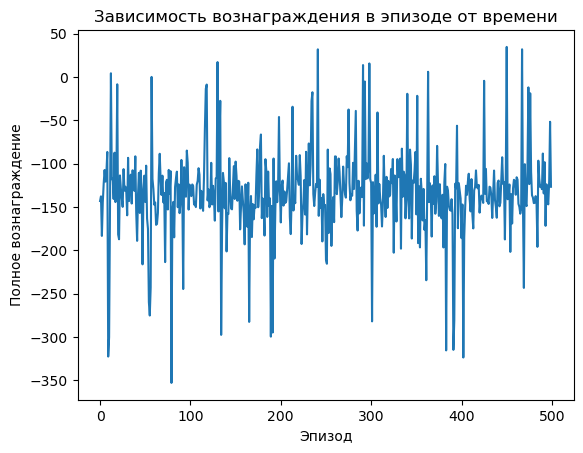

In [ ]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()